## Load raw data and prepare train set

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import codecs

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import re
import pickle

import nltk

In [4]:
file = open('../data/FOMC/statement.pickle', 'rb')

statements = pickle.load(file)
file.close()

statements.index.name = 'Date'
statements.head(10)

,contents
Date,
1994-02-04,Chairman Alan Greenspan announced today that t...
1994-03-22,Chairman Alan Greenspan announced today that t...
1994-04-18,Chairman Alan Greenspan announced today that t...
1994-05-17,The Federal Reserve today announced two action...
1994-08-16,The Federal Reserve announced today the follow...
1994-11-15,The Federal Reserve Board today approved an in...
1995-02-01,For immediate release\n\nThe Federal Reserve B...
1995-07-06,For immediate release\n\nChairman Alan Greensp...
1995-12-19,For immediate release\n\nChairman Alan Greensp...


In [5]:
statements['contents'] = statements['contents'].map(lambda x: x.replace('\n','. ').replace('\r','. '))
statements.head(10)

statements['word_count'] = None
for i in range(len(statements)):
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', statements["contents"][i].lower())
    statements['word_count'][i] = len(input_words)
statements.head(10)

,contents,word_count
Date,,
1994-02-04,Chairman Alan Greenspan announced today that t...,99
1994-03-22,Chairman Alan Greenspan announced today that t...,40
1994-04-18,Chairman Alan Greenspan announced today that t...,37
1994-05-17,The Federal Reserve today announced two action...,160
1994-08-16,The Federal Reserve announced today the follow...,137
1994-11-15,The Federal Reserve Board today approved an in...,139
1995-02-01,For immediate release. . The Federal Reserve B...,144
1995-07-06,For immediate release. . Chairman Alan Greensp...,70
1995-12-19,For immediate release. . Chairman Alan Greensp...,84


In [6]:
#FED Rates
filename = '../data/MarketData/FEDRates/ffs-01172000-02092020.csv'

fedrates = pd.read_csv(filename, header=0, names=('Date', 'Vol', 'EFFR', '1st','25th' ,'75th' ,'99th' ,'Target' ,'Low' ,'High','Std.' ))
fedrates.index = pd.to_datetime(fedrates.Date, format="%d/%m/%Y")
fedrates.dropna(inplace=True, axis=0, subset=['Date', 'Target'])
fedrates.drop(columns=['Date', 'Vol', 'EFFR', '1st','25th' ,'75th' ,'99th','Low' ,'High','Std.'], inplace=True)

fedrates['Low'] = None
fedrates['High'] = None

for i in range(fedrates.shape[0]):
    target = fedrates['Target'][i]
    if '-' in target:
        fedrates['Low'][i] = re.findall(r'([0-9.]+)-', target)[0]
        fedrates['High'][i] = re.findall(r'-([0-9.]+)', target)[0]
    else:
        (fedrates['Low'][i], fedrates['High'][i]) = (target, target)

fedrates

,Target,Low,High
Date,,,
2020-02-06,1.50-1.75,1.50,1.75
2020-02-05,1.50-1.75,1.50,1.75
2020-02-04,1.50-1.75,1.50,1.75
2020-02-03,1.50-1.75,1.50,1.75
2020-01-31,1.50-1.75,1.50,1.75
2020-01-30,1.50-1.75,1.50,1.75
2020-01-29,1.50-1.75,1.50,1.75
2020-01-28,1.50-1.75,1.50,1.75
2020-01-27,1.50-1.75,1.50,1.75


In [7]:
fedrates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4925 entries, 2020-02-06 to 2000-07-03
Data columns (total 3 columns):
Target    4925 non-null object
Low       4925 non-null object
High      4925 non-null object
dtypes: object(3)
memory usage: 313.9+ KB


In [8]:
statements['RateChange'] = None
statements['TargetHigh'] = None

for i in range(len(statements)):
    for j in range(len(fedrates)):
        if statements.index[i] == fedrates.index[j]:
            statements['TargetHigh'][i] = float(fedrates['High'][j-1])
            if fedrates['High'][j-1] == fedrates['High'][j+1]:
                statements['RateChange'][i] = 0
            elif fedrates['High'][j-1] > fedrates['High'][j+1]:
                statements['RateChange'][i] = 1
            elif fedrates['High'][j-1] < fedrates['High'][j+1]:
                statements['RateChange'][i] = -1

statements.tail(100)

,contents,word_count,RateChange,TargetHigh
Date,,,,
2008-03-11,"The Federal Reserve, the central bank of the U...",1481,0,3
2008-03-18,"The Federal Reserve, the central bank of the U...",438,-1,2.25
2008-04-30,"The Federal Reserve, the central bank of the U...",453,-1,2
2008-06-25,"The Federal Reserve, the central bank of the U...",397,0,2
2008-08-05,"The Federal Reserve, the central bank of the U...",392,0,2
2008-09-16,"The Federal Reserve, the central bank of the U...",370,0,2
2008-10-08,"The Federal Reserve, the central bank of the U...",994,-1,1.5
2008-10-29,"The Federal Reserve, the central bank of the U...",436,-1,1
2008-12-16,"The Federal Reserve, the central bank of the U...",550,-1,0.25


In [9]:
statements.dropna(subset=['RateChange'], axis=0, inplace=True)

/Users/yuki/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


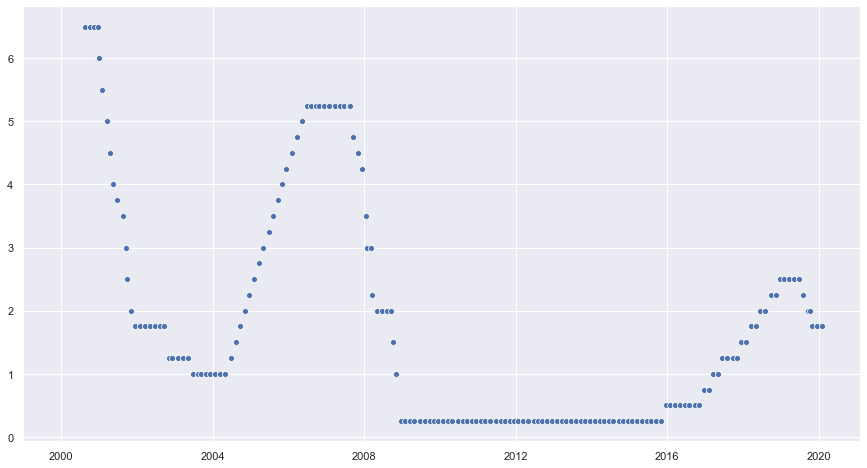

In [10]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot(data=statements["TargetHigh"])

In [34]:
statement_df = pd.DataFrame(statements["contents"])
statement_df["target"] = statements["RateChange"]
statement_df["stmt_date"] = statements.index
statement_df["type"] = "statement"
statement_df.loc[statement_df.index > '2008-11-01']

,contents,target,stmt_date,type
Date,,,,
2008-12-16,"The Federal Reserve, the central bank of the U...",-1,2008-12-16,statement
2009-01-28,"The Federal Reserve, the central bank of the U...",0,2009-01-28,statement
2009-03-18,"The Federal Reserve, the central bank of the U...",0,2009-03-18,statement
2009-04-29,"The Federal Reserve, the central bank of the U...",0,2009-04-29,statement
2009-06-24,"The Federal Reserve, the central bank of the U...",0,2009-06-24,statement
2009-08-12,"The Federal Reserve, the central bank of the U...",0,2009-08-12,statement
2009-09-23,"The Federal Reserve, the central bank of the U...",0,2009-09-23,statement
2009-11-04,"The Federal Reserve, the central bank of the U...",0,2009-11-04,statement
2009-12-16,"The Federal Reserve, the central bank of the U...",0,2009-12-16,statement


In [35]:
statement_df = statement_df.append(
    pd.Series(["The Federal Reserve announced on Tuesday that it will initiate a program to purchase the direct obligations of housing-related government-sponsored enterprises (GSEs)--Fannie Mae, Freddie Mac, and the Federal Home Loan Banks--and mortgage-backed securities (MBS) backed by Fannie Mae, Freddie Mac, and Ginnie Mae.  Spreads of rates on GSE debt and on GSE-guaranteed mortgages have widened appreciably of late.  This action is being taken to reduce the cost and increase the availability of credit for the purchase of houses, which in turn should support housing markets and foster improved conditions in financial markets more generally. Purchases of up to $100 billion in GSE direct obligations under the program will be conducted with the Federal Reserve's primary dealers through a series of competitive auctions and will begin next week.  Purchases of up to $500 billion in MBS will be conducted by asset managers selected via a competitive process with a goal of beginning these purchases before year-end.  Purchases of both direct obligations and MBS are expected to take place over several quarters.  Further information regarding the operational details of this program will be provided after consultation with market participants.", -1, dt.datetime.strptime('2008-11-25', '%Y-%m-%d'),'statement'], index=statement_df.columns, name=dt.datetime.strptime('2008-11-25', '%Y-%m-%d')),
)

In [36]:
statement_df.loc[statement_df.index > '2008-11-01']

,contents,target,stmt_date,type
Date,,,,
2008-12-16,"The Federal Reserve, the central bank of the U...",-1,2008-12-16,statement
2009-01-28,"The Federal Reserve, the central bank of the U...",0,2009-01-28,statement
2009-03-18,"The Federal Reserve, the central bank of the U...",0,2009-03-18,statement
2009-04-29,"The Federal Reserve, the central bank of the U...",0,2009-04-29,statement
2009-06-24,"The Federal Reserve, the central bank of the U...",0,2009-06-24,statement
2009-08-12,"The Federal Reserve, the central bank of the U...",0,2009-08-12,statement
2009-09-23,"The Federal Reserve, the central bank of the U...",0,2009-09-23,statement
2009-11-04,"The Federal Reserve, the central bank of the U...",0,2009-11-04,statement
2009-12-16,"The Federal Reserve, the central bank of the U...",0,2009-12-16,statement


In [14]:
statement_df.loc['2009-03-18', 'target'] = -1
statement_df.loc['2010-11-03', 'target'] = -1
statement_df.loc['2011-09-21', 'target'] = -1
statement_df.loc['2012-06-20', 'target'] = -1
statement_df.loc['2012-09-13', 'target'] = -1
statement_df.loc['2013-12-18', 'target'] = 1

In [22]:
file = open('../data/FOMC/minutes.pickle', 'rb')

minutes_df = pickle.load(file)
file.close()

minutes_df.index.name = 'Date'
minutes_df

,contents
Date,
1993-02-03,A meeting of the Federal Open Market Committee...
1993-03-23,A meeting of the Federal Open Market Committee...
1993-05-18,A meeting of the Federal Open Market Committee...
1993-07-07,A meeting of the Federal Open Market Committee...
1993-08-17,A meeting of the Federal Open Market Committee...
1993-09-21,A meeting of the Federal Open Market Committee...
1993-11-16,A meeting of the Federal Open Market Committee...
1993-12-21,A meeting of the Federal Open Market Committee...
1994-02-04,A meeting of the Federal Open Market Committee...


In [23]:
def get_statement_date(x):
    if statements.index[0] > x:
        return None
    else:
        for i in range(len(statements)):
            if x <= statements.index[i]:
                return statements.index[i]
        return None

def get_rate_change(x):
    if statements.index[0] > x:
        return None
    else:
        for i in range(len(statements)):
            if x <= statements.index[i]:
                return int(statements['RateChange'][i])
        return None

In [24]:
minutes_df['stmt_date'] = None
minutes_df['stmt_date'] = minutes_df.index.map(get_statement_date)
minutes_df['rate_change'] = None
minutes_df['rate_change'] = minutes_df.index.map(get_rate_change)
minutes_df.dropna(inplace=True, axis=0, subset=['stmt_date', 'rate_change'])
minutes_df["type"] = "minutes"
minutes_df

,contents,stmt_date,rate_change,type
Date,,,,
2000-08-22,A meeting of the Federal Open Market Committee...,2000-08-22,0.0,minutes
2000-10-03,A meeting of the Federal Open Market Committee...,2000-10-03,0.0,minutes
2000-11-15,A meeting of the Federal Open Market Committee...,2000-11-15,0.0,minutes
2000-12-19,A meeting of the Federal Open Market Committee...,2000-12-19,0.0,minutes
2000-12-19,A meeting of the Federal Open Market Committee...,2000-12-19,0.0,minutes
2001-01-31,A meeting of the Federal Open Market Committee...,2001-01-31,-1.0,minutes
2001-03-20,A meeting of the Federal Open Market Committee...,2001-03-20,-1.0,minutes
2001-03-20,A meeting of the Federal Open Market Committee...,2001-03-20,-1.0,minutes
2001-03-20,A meeting of the Federal Open Market Committee...,2001-03-20,-1.0,minutes


In [25]:
file = open('../data/FOMC/speech.pickle', 'rb')

speech_df = pickle.load(file)
file.close()

speech_df.index.name = 'Date'
speech_df

,contents
Date,
1996-06-13,Remarks by Chairman Alan Greenspan\nBank super...
1996-06-18,"Remarks by Governor Edward W. Kelley, Jr.\nDev..."
1996-09-08,Monetary Policy Objectives and Strategy\n\r\nI...
1996-09-19,Remarks by Chairman Alan Greenspan\nRegulation...
1996-10-02,Remarks by Governor Lawrence B. Lindsey\r\nAt ...
1996-10-05,Remarks by Chairman Alan Greenspan\nBank super...
1996-10-07,Remarks by Chairman Alan Greenspan\nU.S. Treas...
1996-10-09,Remarks by Governor Lawrence B. Lindsey\r\nAt ...
1996-10-11,Remarks by Governor Lawrence B. Lindsey\r\nAt ...


In [26]:
speech_df['stmt_date'] = None
speech_df['stmt_date'] = speech_df.index.map(get_statement_date)
speech_df['rate_change'] = None
speech_df['rate_change'] = speech_df.index.map(get_rate_change)
speech_df.dropna(inplace=True, axis=0, subset=['stmt_date', 'rate_change'])
speech_df["type"] = "speech"
speech_df

,contents,stmt_date,rate_change,type
Date,,,,
2000-08-25,"This afternoon, bearing my old business econom...",2000-10-03,0.0,speech
2000-08-31,Why Risk Management Is Important for Global Fi...,2000-10-03,0.0,speech
2000-09-15,It is a pleasure to join you this morning to s...,2000-10-03,0.0,speech
2000-09-18,Some Recent Findings regarding the Economic Co...,2000-10-03,0.0,speech
2000-10-11,Perspectives on Innovation in the Retail Payme...,2000-11-15,0.0,speech
2000-10-16,I appreciate this opportunity to address the p...,2000-11-15,0.0,speech
2000-10-19,"For the past two decades, central bankers have...",2000-11-15,0.0,speech
2000-10-19,The Economic Outlook and the Challenges Facing...,2000-11-15,0.0,speech
2000-10-19,Financial Education: The Next Chapter in Commu...,2000-11-15,0.0,speech


In [27]:
file = open('../data/FOMC/script.pickle', 'rb')

script_df = pickle.load(file)
file.close()

script_df.index.name = 'Date'
script_df

,contents
Date,
1990-02-07,"December 16, 2015 Chair Yellen’s Press Confere..."
1990-03-27,FOMC Meeting Transcript\n\n\nMeeting of the Fe...
1990-05-15,FOMC Meeting Transcript\n\n\nMeeting of the Fe...
1990-07-03,FOMC Meeting Transcript\n\n\nMeeting of the Fe...
1990-08-21,FOMC Meeting Transcript\n\n\nMeeting of the Fe...
1990-10-02,FOMC Meeting Transcript\n\n\nMeeting of the Fe...
1990-11-13,FOMC Meeting Transcript\n\n\nMeeting of the Fe...
1990-12-18,FOMC Meeting Transcript\n\n\nMeeting of the Fe...
1991-02-06,FOMC Meeting Transcript\n\n\nMeeting of the Fe...


In [28]:
script_df['stmt_date'] = None
script_df['stmt_date'] = script_df.index.map(get_statement_date)
script_df['rate_change'] = None
script_df['rate_change'] = script_df.index.map(get_rate_change)
script_df.dropna(inplace=True, axis=0, subset=['stmt_date', 'rate_change'])
script_df["type"] = "script"
script_df

,contents,stmt_date,rate_change,type
Date,,,,
2000-08-22,Microsoft Word - Transcript.2000.08.22.doc\n\n...,2000-08-22,0.0,script
2000-10-03,Microsoft Word - Transcript.2000.10.03.doc\n\n...,2000-10-03,0.0,script
2000-11-15,Microsoft Word - Transcript.2000.11.15.doc\n\n...,2000-11-15,0.0,script
2000-12-19,Microsoft Word - Transcript.2000.12.19.doc\n\n...,2000-12-19,0.0,script
2001-01-31,Meeting of the Federal Open Market Committee ...,2001-01-31,-1.0,script
2001-03-20,Meeting of the Federal Open Market Committee ...,2001-03-20,-1.0,script
2001-05-15,Meeting of the Federal Open Market Committee ...,2001-05-15,-1.0,script
2001-06-27,Meeting of the Federal Open Market Committee ...,2001-06-27,-1.0,script
2001-08-21,Meeting of the Federal Open Market Committee ...,2001-08-21,-1.0,script


In [29]:
frames = [statement_df, minutes_df, script_df, speech_df]
df = pd.concat(frames, sort=True)
df

,contents,rate_change,stmt_date,target,type
Date,,,,,
2000-08-22,For immediate release. . . . . . . . . \tThe F...,NaN,2000-08-22,0.0,statement
2000-10-03,For immediate release. . . . . . . . . . . The...,NaN,2000-10-03,0.0,statement
2000-11-15,For immediate release. . . . . . . . . The Fed...,NaN,2000-11-15,0.0,statement
2000-12-19,For immediate release. . . . . . . . . The Fed...,NaN,2000-12-19,0.0,statement
2001-01-03,For immediate release. . . . . . . . . \tThe F...,NaN,2001-01-03,-1.0,statement
2001-01-31,For immediate release. . . . . . . . . The Fed...,NaN,2001-01-31,-1.0,statement
2001-03-20,For immediate release. . . . . . . . . The Fed...,NaN,2001-03-20,-1.0,statement
2001-04-18,For immediate release. . . . . . . . . The Fed...,NaN,2001-04-18,-1.0,statement
2001-05-15,For immediate release. . . . . . The Federal O...,NaN,2001-05-15,-1.0,statement


In [30]:
# Return code
df['contents'] = df['contents'].map(lambda x: x.replace('\n','. ').replace('\r','. '))

# Conver to float
df['rate_change'] = df['rate_change'].map(lambda x: np.float(x))

In [31]:
with open("../data/FOMC/concat_df.pickle", "wb") as file:
    pickle.dump(df, file)

# In case pickle is not available
df.to_csv('../data/FOMC/concat_df.csv', index=True)